In [1]:
import random
from collections import namedtuple
from copy import deepcopy

import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns

from lib.env import TicTacToe

In [2]:
sns.set(rc={'figure.figsize': (13, 6)})
sns.set_style("whitegrid")

In [3]:
class RandomPlayer():

    def __init__(self):
        pass
    
    def next_action(self, env, learn_flag=True):        
        state = env.getState()

        board, actions, _ = state
        actions_cnt = len(actions)

        return random.randint(0, actions_cnt - 1)

    def learn(self, log):
        pass

In [4]:
def run_episode(env, player_x, player_o, learn_flag=True):
    env.reset()

    state = env.getState()
    board, actions, _ = state
    
    done = False
    log_x, log_o = [], []
    
    while not done:
        action_ind = player_x.next_action(env, learn_flag)

        state, reward, done, _ = env.step(actions[action_ind])
        log_x.append([board, len(actions), action_ind, 0])
        board, actions, _ = state
        
        if not done:
            action_ind = player_o.next_action(env, learn_flag)

            state, reward, done, _ = env.step(actions[action_ind])
            log_o.append([board, len(actions), action_ind, 0])
            board, actions, _ = state
            
        if done:
            log_x[-1][-1] = reward
            log_o[-1][-1] = -1 * reward

    if learn_flag:
        player_x.learn(log_x)
        player_o.learn(log_o)

    return reward

In [5]:
def run_all_episodes(env, player_x, player_o, episodes, score_step, score_episodes):
    results = {
        'player_x': [],
        'player_o': [],
        'player_x_fail_rate': [],
        'player_o_fail_rate': [],
        'episode': []
    }

    for i in range(episodes):
        _ = run_episode(env, player_x, player_o)

        if i % score_step == 0:
            scores_x, scores_o = 0, 0
            scores_x_fail, scores_o_fail = 0, 0
            
            for j in range(score_episodes):
                score = run_episode(env, player_x, player_o, learn_flag=False)

                scores_x += score
                scores_o += -1 * score

                if score == -1:
                    scores_x_fail += 1

                if score == 1:
                    scores_o_fail += 1

            results['player_x'].append(scores_x / score_episodes)
            results['player_o'].append(scores_o / score_episodes)
            
            results['player_x_fail_rate'].append(scores_x_fail / score_episodes)
            results['player_o_fail_rate'].append(scores_o_fail / score_episodes)

            results['episode'].append(i)

    return results

In [6]:
episodes, score_step, score_episodes = 100000, 5000, 500

In [7]:
params_3 = (3, 3, 3)
env_3 = TicTacToe(n_rows=params_3[0], n_cols=params_3[1], n_win=params_3[2])

params_4 = (4, 4, 4)
env_4 = TicTacToe(n_rows=params_4[0], n_cols=params_4[1], n_win=params_4[2])

params_5 = (5, 5, 4)
env_5 = TicTacToe(n_rows=params_5[0], n_cols=params_5[1], n_win=params_5[2])

In [8]:
def draw_stat(params, player_x_name, player_o_name, episodes, results):
    results_df = pd.DataFrame(results).set_index('episode', drop=True)
    score_x, score_o = results['player_x'][-1], results['player_o'][-1]
    
    fig, axs = plt.subplots(ncols=2)

    g = sns.lineplot(
        data=results_df[['player_x', 'player_o']],
        ax=axs[0],
        palette='viridis')
    
    title = """
        TicTacToe %s. Episodes: %d. Rewards.
        %s [X]: %f vs RandomPlayer [O].
        %s [O]: %f vs RandomPlayer [X].
    """ % (
        params, episodes,
        player_x_name, results['player_x'][-1],
        player_o_name, results['player_o'][-1])

    g.set_title(title)
    g.set_ylabel('reward')
    g.set_xlabel('episodes')
    g.set(ylim=(-1, 1))
    
    g = sns.lineplot(
        data=results_df[['player_x_fail_rate', 'player_o_fail_rate']],
        ax=axs[1],
        palette='rocket')
    
    title = """
        TicTacToe %s. Episodes: %d. Fail Rate.
        %s [X]: %f vs RandomPlayer [O].
        %s [O]: %f vs RandomPlayer [X].
    """ % (
        params, episodes,
        player_x_name, results['player_x_fail_rate'][-1],
        player_o_name, results['player_o_fail_rate'][-1])

    g.set_title(title)
    g.set_ylabel('fail_rate')
    g.set_xlabel('episodes')
    g.set(ylim=(0, 1))

In [9]:
player_x_random = RandomPlayer()
player_o_random = RandomPlayer()

results_random_3 = run_all_episodes(
    env_3,
    player_x_random,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

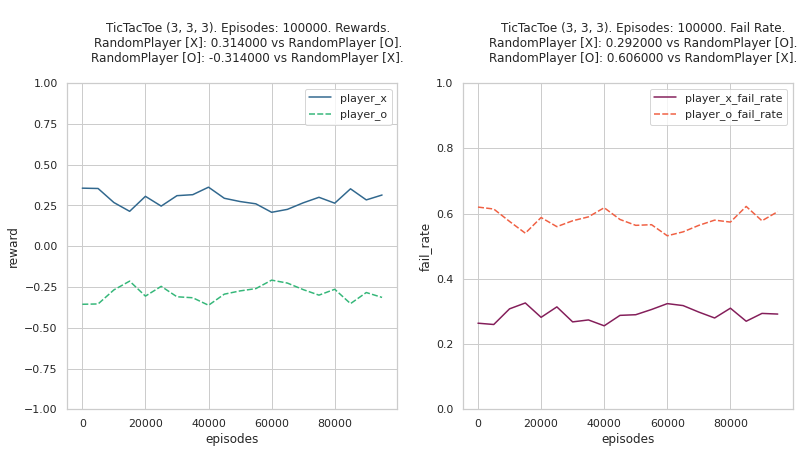

In [10]:
draw_stat(params_3, 'RandomPlayer', 'RandomPlayer', episodes, results_random_3)

In [11]:
player_x_random = RandomPlayer()
player_o_random = RandomPlayer()

results_random_4 = run_all_episodes(
    env_4,
    player_x_random,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

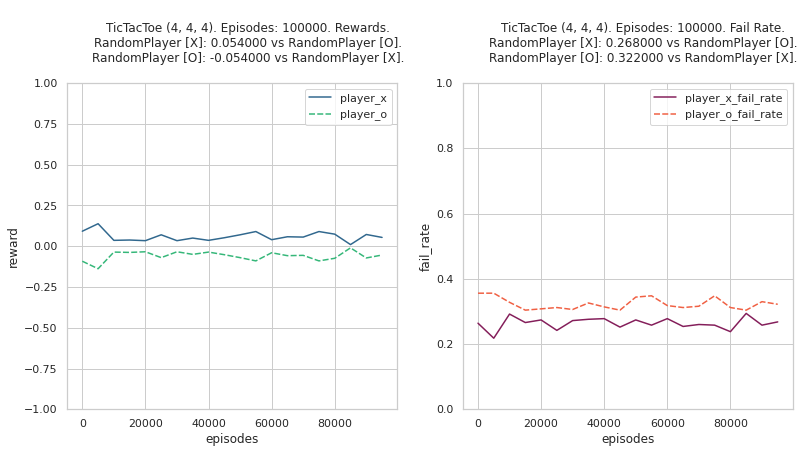

In [12]:
draw_stat(params_4, 'RandomPlayer', 'RandomPlayer', episodes, results_random_4)

In [13]:
player_x_random = RandomPlayer()
player_o_random = RandomPlayer()

results_random_5 = run_all_episodes(
    env_5,
    player_x_random,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

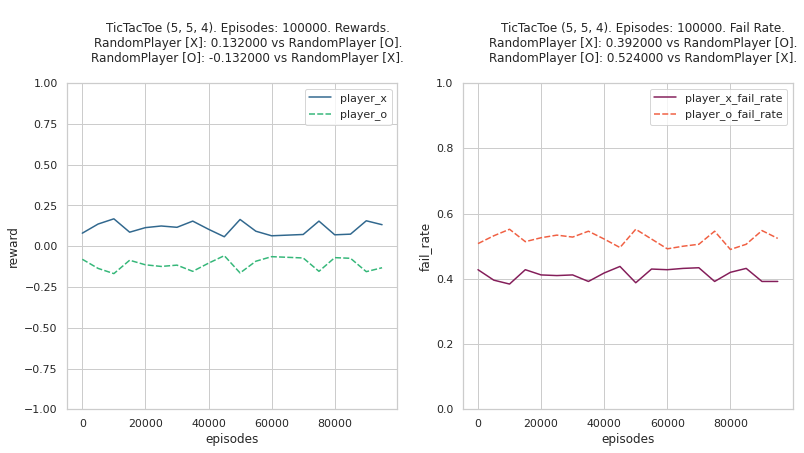

In [14]:
draw_stat(params_5, 'RandomPlayer', 'RandomPlayer', episodes, results_random_5)

In [15]:
class QlearningPlayer():

    def __init__(self, learning_rate=0.1, discount=1, epsilon=0.01):
        self.Q = {}

        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon
    
    def next_action(self, env, learn_flag=True):
        state = env.getState()

        board, actions, _ = state
        actions_cnt = len(actions)
        
        if learn_flag and random.random() < self.epsilon:
            return random.randint(0, actions_cnt - 1)
        
        if board in self.Q:
            return np.argmax(self.Q[board])

        return random.randint(0, actions_cnt - 1)

    def learn(self, log):
        max_Q_next = 0
        
        for item in log[::-1]:
            board, actions_cnt, action_ind, reward_i = item
            
            if board not in self.Q:
                self.Q[board] = np.full(actions_cnt, 1 / actions_cnt)
                
            self.Q[board][action_ind] = (
                self.Q[board][action_ind] +
                self.learning_rate * (
                    reward_i +
                    self.discount * max_Q_next -
                    self.Q[board][action_ind]
                )
            )

            max_Q_next = np.max(self.Q[board])

In [16]:
player_x_q_3 = QlearningPlayer()
player_o_q_3 = QlearningPlayer()

results_x = run_all_episodes(
    env_3,
    player_x_q_3,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_3,
    player_x_random,
    player_o_q_3,
    episodes,
    score_step,
    score_episodes
)

results_q_3 = {}

results_q_3['episode'] = results_x['episode']
results_q_3['player_x'] = results_x['player_x']
results_q_3['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_q_3['player_o'] = results_o['player_o']
results_q_3['player_o_fail_rate'] = results_o['player_o_fail_rate']

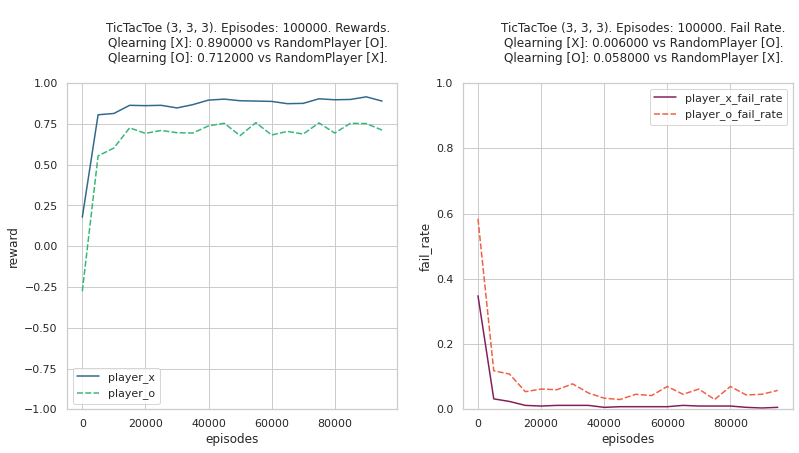

In [17]:
draw_stat(params_3, 'Qlearning', 'Qlearning', episodes, results_q_3)

In [18]:
player_x_q_4 = QlearningPlayer()
player_o_q_4 = QlearningPlayer()

results_x = run_all_episodes(
    env_4,
    player_x_q_4,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_4,
    player_x_random,
    player_o_q_4,
    episodes,
    score_step,
    score_episodes
)

results_q_4 = {}

results_q_4['episode'] = results_x['episode']
results_q_4['player_x'] = results_x['player_x']
results_q_4['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_q_4['player_o'] = results_o['player_o']
results_q_4['player_o_fail_rate'] = results_o['player_o_fail_rate']

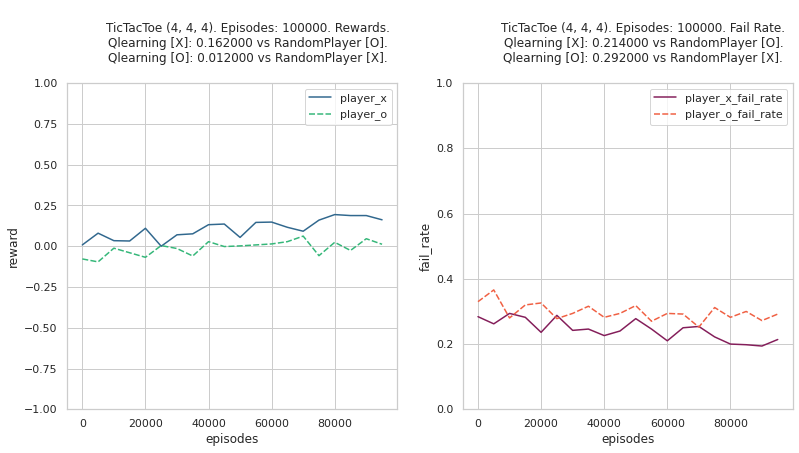

In [19]:
draw_stat(params_4, 'Qlearning', 'Qlearning', episodes, results_q_4)

In [20]:
player_x_q_5 = QlearningPlayer()
player_o_q_5 = QlearningPlayer()

results_x = run_all_episodes(
    env_5,
    player_x_q_5,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_5,
    player_x_random,
    player_o_q_5,
    episodes,
    score_step,
    score_episodes
)

results_q_5 = {}

results_q_5['episode'] = results_x['episode']
results_q_5['player_x'] = results_x['player_x']
results_q_5['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_q_5['player_o'] = results_o['player_o']
results_q_5['player_o_fail_rate'] = results_o['player_o_fail_rate']

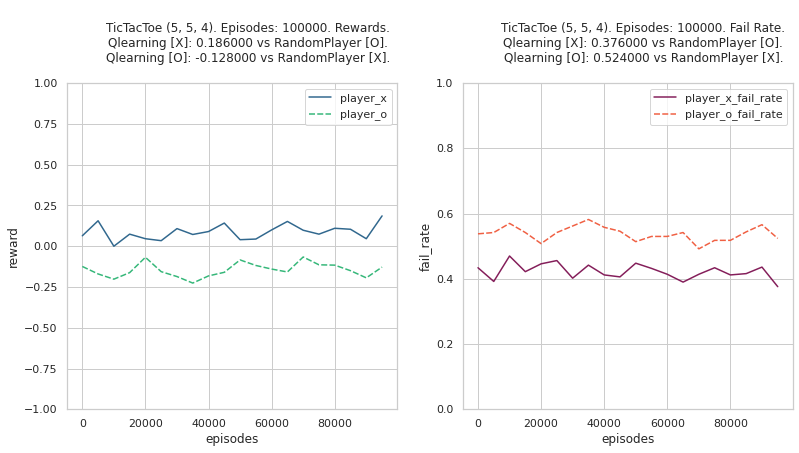

In [21]:
draw_stat(params_5, 'Qlearning', 'Qlearning', episodes, results_q_5)

In [22]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [23]:
class Network(nn.Module):

    def __init__(self, n_rows, n_cols):
        super().__init__()
        size = n_rows * n_cols
        self.l1 = nn.Linear(size, size)
        self.l2 = nn.Linear(size, size)
        self.l3 = nn.Linear(size, size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.l3(x)
        return F.softmax(x, dim=1)

In [24]:
def board_to_vec(board):
    return [int(x) - 1 for x in board]

def convert_action_ind_to_action(board, action_ind):
    vec = board_to_vec(board)
    
    zero_cnt = 0
    
    for i in range(len(vec)):
        if vec[i] == 0:
            if zero_cnt == action_ind:
                return i
            zero_cnt += 1

def next_board_vec(board, action_ind):
    vec = [int(x) - 1 for x in board]

    action = convert_action_ind_to_action(board, action_ind)

    x_cnt = len([x for x in vec if x == 1])
    o_cnt = len([x for x in vec if x == -1])

    vec[action] = 1 if x_cnt == o_cnt else -1

    return vec

def board_mask(board):
    return [0 if int(x) - 1 != 0 else 1 for x in board]

def convert_action_to_action_ind(board, action):
    vec = board_to_vec(board)

    action_ind = 0
    
    for i, x in enumerate(vec):
        if i == action:
            return action_ind
        if x == 0:
            action_ind += 1

In [25]:
class DQNPlayer():

    def __init__(
            self, n_rows, n_cols,
            memory_size=50000, batch_size=128, epsilon=0.01):

        self.model = Network(n_rows, n_cols).to(device)
        self.memory = ReplayMemory(memory_size)

        self.epsilon = epsilon
        self.batch_size = batch_size

        self.optimizer = optim.Adam(self.model.parameters(), 0.001)

    def next_action(self, env, learn_flag=True):
        state = env.getState()

        board, actions, _ = state
        actions_cnt = len(actions)

        if learn_flag and random.random() < self.epsilon:
            return random.randint(0, actions_cnt - 1)
        
        state = torch.tensor([board_to_vec(board)], dtype=torch.float32)
        mask = torch.tensor([board_mask(board)], dtype=torch.float32)
        action = int((self.model(state) * mask).max(1)[1])

        return min(convert_action_to_action_ind(board, action), actions_cnt - 1)

    def learn(self, log):
        for item in log:
            board, actions_cnt, action_ind, reward_i = item
            
            state = torch.tensor([board_to_vec(board)], dtype=torch.float32)
            action = torch.tensor([[convert_action_ind_to_action(board, action_ind)]], dtype=torch.int64)
            next_state = torch.tensor([next_board_vec(board, action_ind)], dtype=torch.float32)
            reward = torch.tensor([reward_i], dtype=torch.float32)

            self.memory.push(state, action, next_state, reward)
            
        if len(self.memory) <= self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        batch_state = torch.cat(batch.state)
        batch_action = torch.cat(batch.action)
        batch_reward = torch.cat(batch.reward)
        batch_next_state = torch.cat(batch.next_state)

        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        Qnext = self.model(batch_next_state).max(1)[0].detach() + batch_reward

        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [26]:
player_x_dqn_3 = DQNPlayer(params_3[0], params_3[1])
player_o_dqn_3 = DQNPlayer(params_3[0], params_3[1])

results_x = run_all_episodes(
    env_3,
    player_x_dqn_3,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_3,
    player_x_random,
    player_o_dqn_3,
    episodes,
    score_step,
    score_episodes
)

results_dqn_3 = {}

results_dqn_3['episode'] = results_x['episode']
results_dqn_3['player_x'] = results_x['player_x']
results_dqn_3['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_dqn_3['player_o'] = results_o['player_o']
results_dqn_3['player_o_fail_rate'] = results_o['player_o_fail_rate']

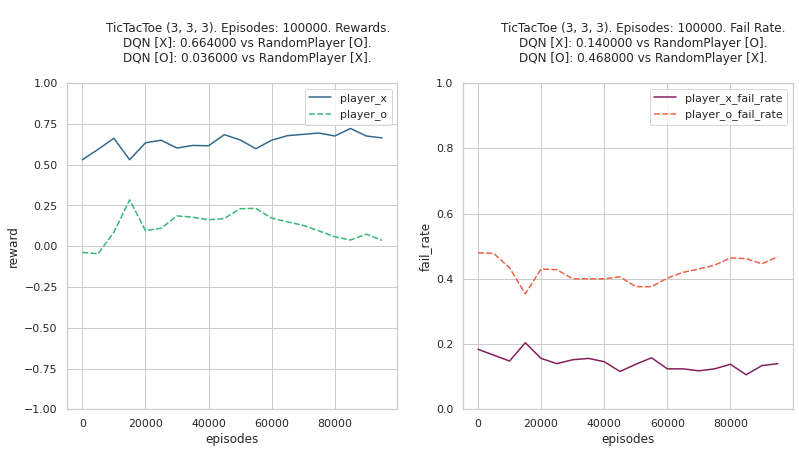

In [27]:
draw_stat(params_3, 'DQN', 'DQN', episodes, results_dqn_3)

In [28]:
player_x_dqn_4 = DQNPlayer(params_4[0], params_4[1])
player_o_dqn_4 = DQNPlayer(params_4[0], params_4[1])

results_x = run_all_episodes(
    env_4,
    player_x_dqn_4,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_4,
    player_x_random,
    player_o_dqn_4,
    episodes,
    score_step,
    score_episodes
)

results_dqn_4 = {}

results_dqn_4['episode'] = results_x['episode']
results_dqn_4['player_x'] = results_x['player_x']
results_dqn_4['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_dqn_4['player_o'] = results_o['player_o']
results_dqn_4['player_o_fail_rate'] = results_o['player_o_fail_rate']

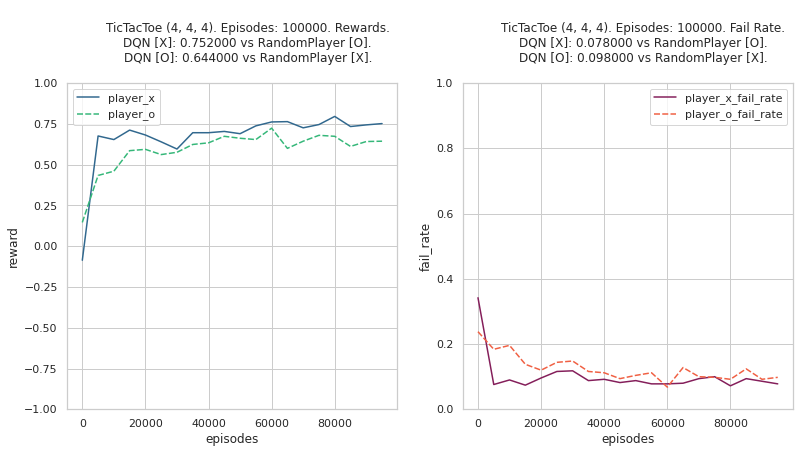

In [29]:
draw_stat(params_4, 'DQN', 'DQN', episodes, results_dqn_4)

In [30]:
player_x_dqn_5 = DQNPlayer(params_5[0], params_5[1])
player_o_dqn_5 = DQNPlayer(params_5[0], params_5[1])

results_x = run_all_episodes(
    env_5,
    player_x_dqn_5,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_5,
    player_x_random,
    player_o_dqn_5,
    episodes,
    score_step,
    score_episodes
)

results_dqn_5 = {}

results_dqn_5['episode'] = results_x['episode']
results_dqn_5['player_x'] = results_x['player_x']
results_dqn_5['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_dqn_5['player_o'] = results_o['player_o']
results_dqn_5['player_o_fail_rate'] = results_o['player_o_fail_rate']

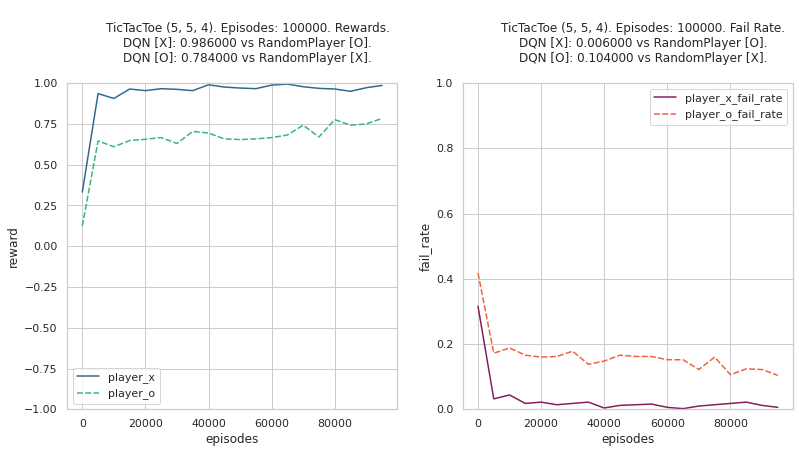

In [31]:
draw_stat(params_5, 'DQN', 'DQN', episodes, results_dqn_5)

In [32]:
class DoubleDQNPlayer():

    def __init__(
            self, n_rows, n_cols,
            memory_size=50000, batch_size=128, epsilon=0.01):

        self.model1 = Network(n_rows, n_cols).to(device)
        self.model2 = Network(n_rows, n_cols).to(device)

        self.memory = ReplayMemory(memory_size)

        self.epsilon = epsilon
        self.batch_size = batch_size

        self.optimizer = optim.Adam(self.model1.parameters(), 0.001)

    def next_action(self, env, learn_flag=True):
        state = env.getState()

        board, actions, _ = state
        actions_cnt = len(actions)

        if learn_flag and random.random() < self.epsilon:
            return random.randint(0, actions_cnt - 1)
        
        state = torch.tensor([board_to_vec(board)], dtype=torch.float32)
        mask = torch.tensor([board_mask(board)], dtype=torch.float32)
        action = int((self.model1(state) * mask).max(1)[1])

        return min(convert_action_to_action_ind(board, action), actions_cnt - 1)

    def learn(self, log):
        for item in log:
            board, actions_cnt, action_ind, reward_i = item
            
            state = torch.tensor([board_to_vec(board)], dtype=torch.float32)
            action = torch.tensor([[convert_action_ind_to_action(board, action_ind)]], dtype=torch.int64)
            next_state = torch.tensor([next_board_vec(board, action_ind)], dtype=torch.float32)
            reward = torch.tensor([reward_i], dtype=torch.float32)

            self.memory.push(state, action, next_state, reward)
            
        if len(self.memory) <= self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        batch_state = torch.cat(batch.state)
        batch_action = torch.cat(batch.action)
        batch_reward = torch.cat(batch.reward)
        batch_next_state = torch.cat(batch.next_state)
        
        Q1 = self.model1(batch_state).gather(1, batch_action).reshape([self.batch_size])
        
        Q_max_ind = torch.argmax(self.model1(batch_next_state).detach(), dim=1)
        Qnext = self.model2(batch_next_state).gather(1, Q_max_ind.unsqueeze(1))[0].detach() + batch_reward

        loss = F.smooth_l1_loss(Q1, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if random.random() < 0.1:
            for model2_param, model1_param in zip(self.model2.parameters(), self.model1.parameters()):
                model2_param.data.copy_(model1_param)

In [33]:
player_x_ddqn_3 = DoubleDQNPlayer(params_3[0], params_3[1])
player_o_ddqn_3 = DoubleDQNPlayer(params_3[0], params_3[1])

results_x = run_all_episodes(
    env_3,
    player_x_ddqn_3,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_3,
    player_x_random,
    player_o_ddqn_3,
    episodes,
    score_step,
    score_episodes
)

results_ddqn_3 = {}

results_ddqn_3['episode'] = results_x['episode']
results_ddqn_3['player_x'] = results_x['player_x']
results_ddqn_3['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_ddqn_3['player_o'] = results_o['player_o']
results_ddqn_3['player_o_fail_rate'] = results_o['player_o_fail_rate']

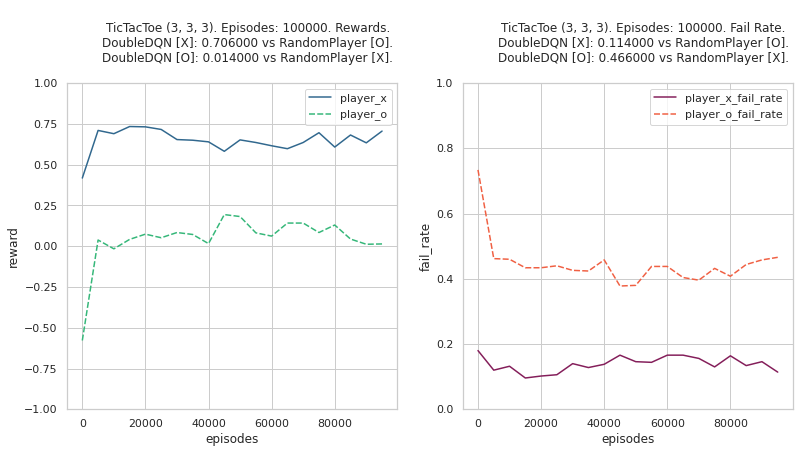

In [34]:
draw_stat(params_3, 'DoubleDQN', 'DoubleDQN', episodes, results_ddqn_3)

In [35]:
player_x_ddqn_4 = DoubleDQNPlayer(params_4[0], params_4[1])
player_o_ddqn_4 = DoubleDQNPlayer(params_4[0], params_4[1])

results_x = run_all_episodes(
    env_4,
    player_x_ddqn_4,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_4,
    player_x_random,
    player_o_ddqn_4,
    episodes,
    score_step,
    score_episodes
)

results_ddqn_4 = {}

results_ddqn_4['episode'] = results_x['episode']
results_ddqn_4['player_x'] = results_x['player_x']
results_ddqn_4['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_ddqn_4['player_o'] = results_o['player_o']
results_ddqn_4['player_o_fail_rate'] = results_o['player_o_fail_rate']

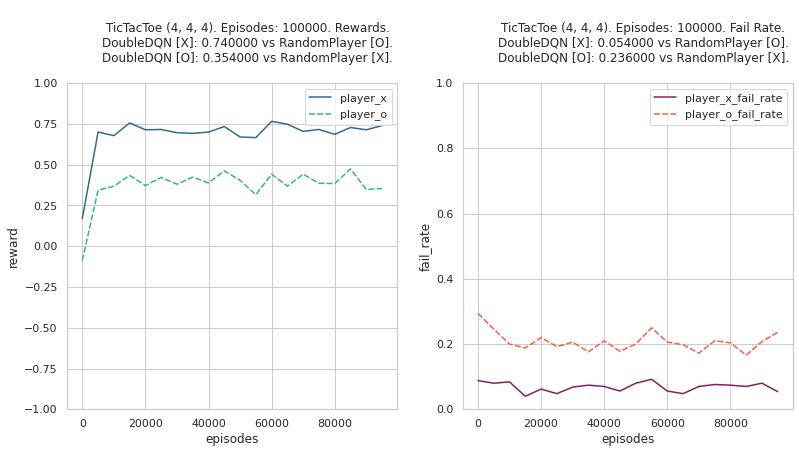

In [36]:
draw_stat(params_4, 'DoubleDQN', 'DoubleDQN', episodes, results_ddqn_4)

In [37]:
player_x_ddqn_5 = DoubleDQNPlayer(params_5[0], params_5[1])
player_o_ddqn_5 = DoubleDQNPlayer(params_5[0], params_5[1])

results_x = run_all_episodes(
    env_5,
    player_x_ddqn_5,
    player_o_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_5,
    player_x_random,
    player_o_ddqn_5,
    episodes,
    score_step,
    score_episodes
)

results_ddqn_5 = {}

results_ddqn_5['episode'] = results_x['episode']
results_ddqn_5['player_x'] = results_x['player_x']
results_ddqn_5['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_ddqn_5['player_o'] = results_o['player_o']
results_ddqn_5['player_o_fail_rate'] = results_o['player_o_fail_rate']

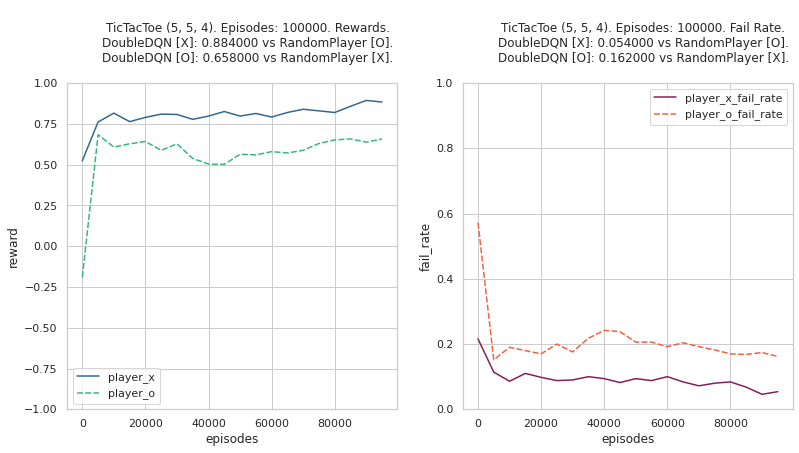

In [38]:
draw_stat(params_5, 'DoubleDQN', 'DoubleDQN', episodes, results_ddqn_5)

In [39]:
del player_x_q_3
del player_o_q_3

del player_x_q_4
del player_o_q_4

del player_x_q_5
del player_o_q_5

del player_x_dqn_3
del player_o_dqn_3

del player_x_dqn_4
del player_o_dqn_4

del player_x_dqn_5
del player_o_dqn_5

del player_x_ddqn_3
del player_o_ddqn_3

del player_x_ddqn_4
del player_o_ddqn_4

del player_x_ddqn_5
del player_o_ddqn_5

In [40]:
def rollouts(env, player_1, player_2, count=1):
    
    playouts = []

    for i in range(count):
        copy_env = deepcopy(env)
        
        state = copy_env.getState()

        board, actions, _ = state
        actions_cnt = len(actions)

        done = False
        log = []

        while not done:
            action_ind = player_1.next_action(copy_env, learn_flag=False)

            state, reward, done, _ = copy_env.step(actions[action_ind])
            log_tmp_item = [board, len(actions), action_ind, 0]
            board, actions, _ = state

            if not done:
                action_ind = player_2.next_action(copy_env, learn_flag=False)

                state, reward, done, _ = copy_env.step(actions[action_ind])
                board, actions, _ = state
                
                if done:
                    log_tmp_item[-1] = -1 * reward
            else:
                log_tmp_item[-1] = reward

            log.append(log_tmp_item)

        playouts.append(log)

    return playouts

In [41]:
class TreeNode():

    def __init__(self, actions_cnt, parent=None):
        self.actions_cnt = actions_cnt
        self.wins = 0
        self.simulations = 0
        self.parent = parent
        self.board_children = {}

In [42]:
class MCTSPlayer():

    def __init__(self, player, n_rows, n_cols):
        self.player = player
        self.n_rows = n_rows
        self.n_cols = n_cols

        self.root = TreeNode(n_rows * n_cols)
        self.curr_node = None

    def next_action(self, env, learn_flag=True):
        state = env.getState()

        board, actions, _ = state
        actions_cnt = len(actions)
        
        if self.n_rows * self.n_cols - actions_cnt < 2:
            self.curr_node = self.root
        
        if board not in self.curr_node.board_children:
            self.curr_node.board_children[board] = []

        if not len(self.curr_node.board_children[board]):
            for i in range(actions_cnt):
                new_node = TreeNode(actions_cnt - 2, self.curr_node)
                self.curr_node.board_children[board].append(new_node)
            
            self.curr_node.board_children[board] = tuple(self.curr_node.board_children[board])

        if self.curr_node.simulations == 0:
            playouts = rollouts(env, self.player, self.player)
            tmp_node = self.curr_node

            for log in playouts:
                self.curr_node = tmp_node
                self.learn(log)

            self.curr_node = tmp_node
        
        scores = []
        sum_simulations = sum([
            x.simulations for x in self.curr_node.board_children[board]
        ])
        
        for i in range(actions_cnt):
            w = self.curr_node.board_children[board][i].wins
            n = self.curr_node.board_children[board][i].simulations

            if learn_flag:
                if n != 0 and sum_simulations != 0:
                    score = w / n + np.sqrt(2 * np.log(sum_simulations) / n)
                else:
                    score = 1
            else:
                if n != 0:
                    score = w / n
                else:
                    score = 0.0

            scores.append(score)

        action_ind = np.argmax(scores)
        self.curr_node = self.curr_node.board_children[board][action_ind]

        return action_ind

    def learn(self, log):
        for i, item in enumerate(log):
            board, actions_cnt, action_ind, reward_i = item
            
            if self.n_rows * self.n_cols - actions_cnt < 2:
                self.curr_node = self.root
        
            if board not in self.curr_node.board_children:
                self.curr_node.board_children[board] = []

            if not len(self.curr_node.board_children[board]):
                for i in range(actions_cnt):
                    new_node = TreeNode(actions_cnt - 2, self.curr_node)
                    self.curr_node.board_children[board].append(new_node)
                    
                self.curr_node.board_children[board] = tuple(self.curr_node.board_children[board])

            if i == len(log) - 1:
                tmp_parent = self.curr_node.parent

                while tmp_parent:
                    tmp_parent.simulations += 1
                    tmp_parent.wins += (reward_i + 1) / 2
                    tmp_parent = tmp_parent.parent

            self.curr_node = self.curr_node.board_children[board][action_ind]

In [43]:
player_random = RandomPlayer()

player_x_mcts_3 = MCTSPlayer(player_random, params_3[0], params_3[1])
player_o_mcts_3 = MCTSPlayer(player_random, params_3[0], params_3[1])

results_x = run_all_episodes(
    env_3,
    player_x_mcts_3,
    player_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_3,
    player_random,
    player_o_mcts_3,
    episodes,
    score_step,
    score_episodes
)

results_mcts_3 = {}

results_mcts_3['episode'] = results_x['episode']
results_mcts_3['player_x'] = results_x['player_x']
results_mcts_3['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_mcts_3['player_o'] = results_o['player_o']
results_mcts_3['player_o_fail_rate'] = results_o['player_o_fail_rate']

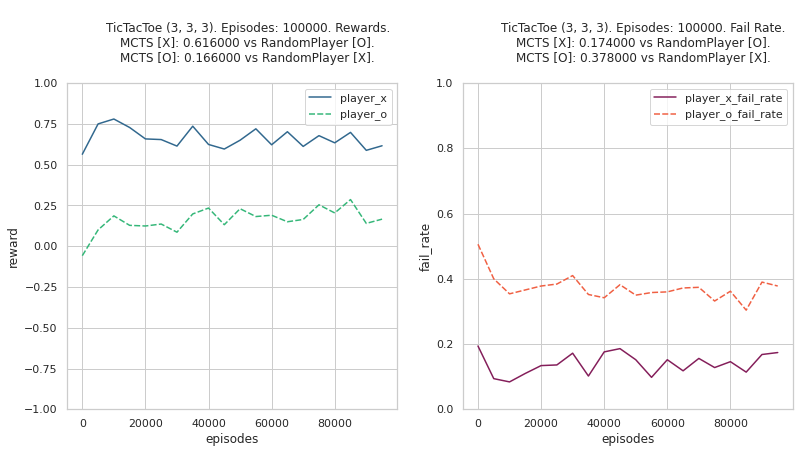

In [44]:
draw_stat(params_3, 'MCTS', 'MCTS', episodes, results_mcts_3)

In [45]:
del player_x_mcts_3
del player_o_mcts_3

In [46]:
player_random = RandomPlayer()

player_x_mcts_4 = MCTSPlayer(player_random, params_4[0], params_4[1])
player_o_mcts_4 = MCTSPlayer(player_random, params_4[0], params_4[1])

results_x = run_all_episodes(
    env_4,
    player_x_mcts_4,
    player_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_4,
    player_random,
    player_o_mcts_4,
    episodes,
    score_step,
    score_episodes
)

results_mcts_4 = {}

results_mcts_4['episode'] = results_x['episode']
results_mcts_4['player_x'] = results_x['player_x']
results_mcts_4['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_mcts_4['player_o'] = results_o['player_o']
results_mcts_4['player_o_fail_rate'] = results_o['player_o_fail_rate']

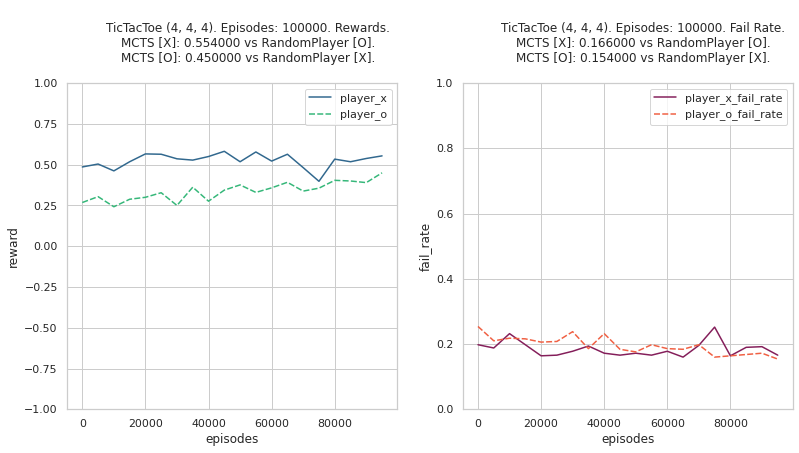

In [47]:
draw_stat(params_4, 'MCTS', 'MCTS', episodes, results_mcts_4)

In [48]:
del player_x_mcts_4
del player_o_mcts_4

In [49]:
player_random = RandomPlayer()

player_x_mcts_5 = MCTSPlayer(player_random, params_5[0], params_5[1])
player_o_mcts_5 = MCTSPlayer(player_random, params_5[0], params_5[1])

results_x = run_all_episodes(
    env_5,
    player_x_mcts_5,
    player_random,
    episodes,
    score_step,
    score_episodes
)

results_o = run_all_episodes(
    env_5,
    player_random,
    player_o_mcts_5,
    episodes,
    score_step,
    score_episodes
)

results_mcts_5 = {}

results_mcts_5['episode'] = results_x['episode']
results_mcts_5['player_x'] = results_x['player_x']
results_mcts_5['player_x_fail_rate'] = results_x['player_x_fail_rate']
results_mcts_5['player_o'] = results_o['player_o']
results_mcts_5['player_o_fail_rate'] = results_o['player_o_fail_rate']

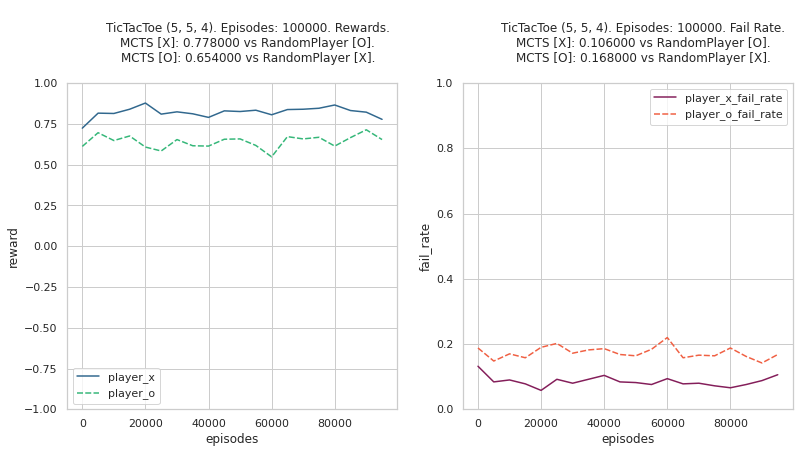

In [50]:
draw_stat(params_5, 'MCTS', 'MCTS', episodes, results_mcts_5)

[(0.0, 1.0)]

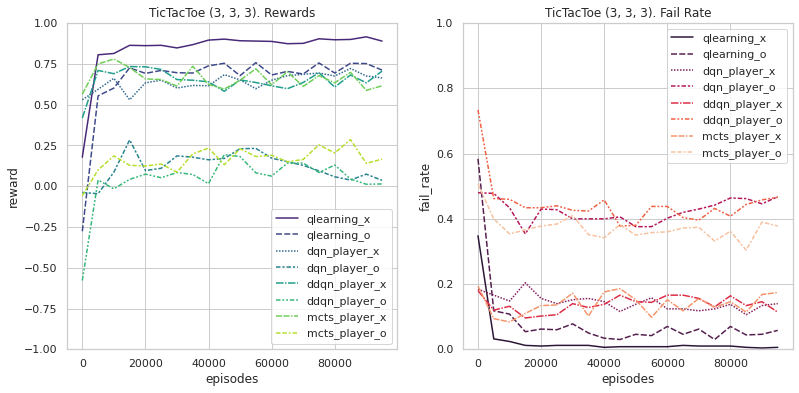

In [51]:
results_df = pd.DataFrame({
    'episode': results_q_3['episode'],
    'qlearning_x': results_q_3['player_x'],
    'qlearning_o': results_q_3['player_o'],
    'dqn_player_x': results_dqn_3['player_x'],
    'dqn_player_o': results_dqn_3['player_o'],
    'ddqn_player_x': results_ddqn_3['player_x'],
    'ddqn_player_o': results_ddqn_3['player_o'],
    'mcts_player_x': results_mcts_3['player_x'],
    'mcts_player_o': results_mcts_3['player_o']
}).set_index('episode', drop=True)

fig, axs = plt.subplots(ncols=2)

g = sns.lineplot(
    data=results_df,
    ax=axs[0],
    palette='viridis')

title = "TicTacToe %s. Rewards" % str(params_3)

g.set_title(title)
g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

results_df = pd.DataFrame({
    'episode': results_q_3['episode'],
    'qlearning_x': results_q_3['player_x_fail_rate'],
    'qlearning_o': results_q_3['player_o_fail_rate'],
    'dqn_player_x': results_dqn_3['player_x_fail_rate'],
    'dqn_player_o': results_dqn_3['player_o_fail_rate'],
    'ddqn_player_x': results_ddqn_3['player_x_fail_rate'],
    'ddqn_player_o': results_ddqn_3['player_o_fail_rate'],
    'mcts_player_x': results_mcts_3['player_x_fail_rate'],
    'mcts_player_o': results_mcts_3['player_o_fail_rate']
}).set_index('episode', drop=True)

g = sns.lineplot(
    data=results_df,
    ax=axs[1],
    palette='rocket')

title = "TicTacToe %s. Fail Rate" % str(params_3)

g.set_title(title)
g.set_ylabel('fail_rate')
g.set_xlabel('episodes')
g.set(ylim=(0, 1))

[(0.0, 1.0)]

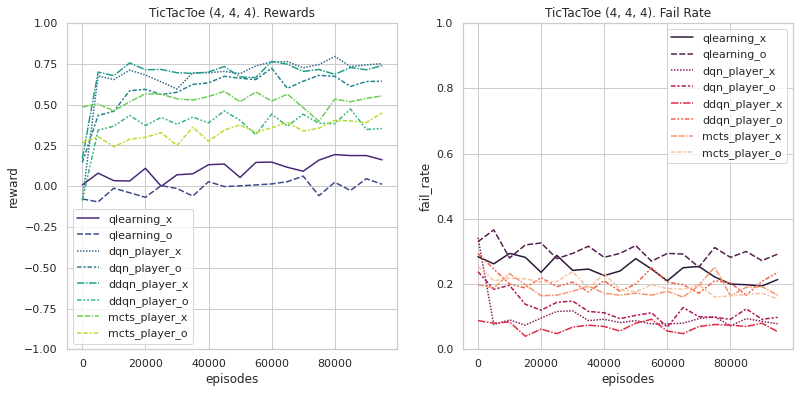

In [52]:
results_df = pd.DataFrame({
    'episode': results_q_4['episode'],
    'qlearning_x': results_q_4['player_x'],
    'qlearning_o': results_q_4['player_o'],
    'dqn_player_x': results_dqn_4['player_x'],
    'dqn_player_o': results_dqn_4['player_o'],
    'ddqn_player_x': results_ddqn_4['player_x'],
    'ddqn_player_o': results_ddqn_4['player_o'],
    'mcts_player_x': results_mcts_4['player_x'],
    'mcts_player_o': results_mcts_4['player_o']
}).set_index('episode', drop=True)

fig, axs = plt.subplots(ncols=2)

g = sns.lineplot(
    data=results_df,
    ax=axs[0],
    palette='viridis')

title = "TicTacToe %s. Rewards" % str(params_4)

g.set_title(title)
g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

results_df = pd.DataFrame({
    'episode': results_q_4['episode'],
    'qlearning_x': results_q_4['player_x_fail_rate'],
    'qlearning_o': results_q_4['player_o_fail_rate'],
    'dqn_player_x': results_dqn_4['player_x_fail_rate'],
    'dqn_player_o': results_dqn_4['player_o_fail_rate'],
    'ddqn_player_x': results_ddqn_4['player_x_fail_rate'],
    'ddqn_player_o': results_ddqn_4['player_o_fail_rate'],
    'mcts_player_x': results_mcts_4['player_x_fail_rate'],
    'mcts_player_o': results_mcts_4['player_o_fail_rate']
}).set_index('episode', drop=True)

g = sns.lineplot(
    data=results_df,
    ax=axs[1],
    palette='rocket')

title = "TicTacToe %s. Fail Rate" % str(params_4)

g.set_title(title)
g.set_ylabel('fail_rate')
g.set_xlabel('episodes')
g.set(ylim=(0, 1))

[(0.0, 1.0)]

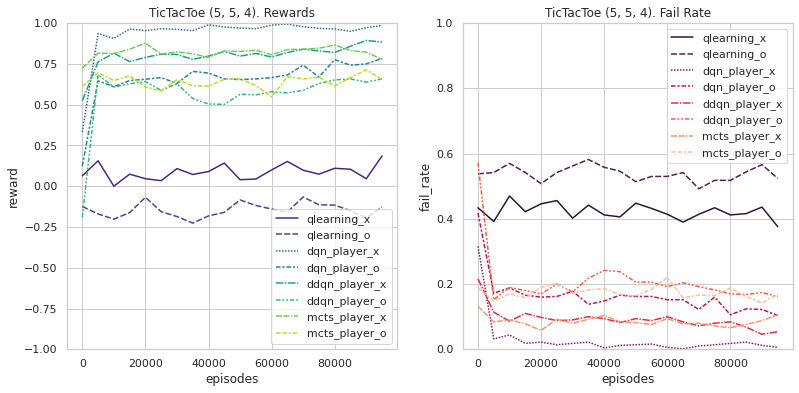

In [53]:
results_df = pd.DataFrame({
    'episode': results_q_5['episode'],
    'qlearning_x': results_q_5['player_x'],
    'qlearning_o': results_q_5['player_o'],
    'dqn_player_x': results_dqn_5['player_x'],
    'dqn_player_o': results_dqn_5['player_o'],
    'ddqn_player_x': results_ddqn_5['player_x'],
    'ddqn_player_o': results_ddqn_5['player_o'],
    'mcts_player_x': results_mcts_5['player_x'],
    'mcts_player_o': results_mcts_5['player_o']
}).set_index('episode', drop=True)

fig, axs = plt.subplots(ncols=2)

g = sns.lineplot(
    data=results_df,
    ax=axs[0],
    palette='viridis')

title = "TicTacToe %s. Rewards" % str(params_5)

g.set_title(title)
g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

results_df = pd.DataFrame({
    'episode': results_q_5['episode'],
    'qlearning_x': results_q_5['player_x_fail_rate'],
    'qlearning_o': results_q_5['player_o_fail_rate'],
    'dqn_player_x': results_dqn_5['player_x_fail_rate'],
    'dqn_player_o': results_dqn_5['player_o_fail_rate'],
    'ddqn_player_x': results_ddqn_5['player_x_fail_rate'],
    'ddqn_player_o': results_ddqn_5['player_o_fail_rate'],
    'mcts_player_x': results_mcts_5['player_x_fail_rate'],
    'mcts_player_o': results_mcts_5['player_o_fail_rate']
}).set_index('episode', drop=True)

g = sns.lineplot(
    data=results_df,
    ax=axs[1],
    palette='rocket')

title = "TicTacToe %s. Fail Rate" % str(params_5)

g.set_title(title)
g.set_ylabel('fail_rate')
g.set_xlabel('episodes')
g.set(ylim=(0, 1))